In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!pip install tensorflow
!pip install tensorflow_federated

In [ ]:
# 1. Import libraries
import os
import glob
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

In [ ]:

# Constants
N_INPUT = 168
N_OUTPUT = 24
BATCH_SIZE = 32
EPOCHS = 3
ONE_YEAR_HOURS = 24 * 365
num_features = 2          # 'kwh', 'm3h'
DATA_DIR = "/content/drive/MyDrive/thesis_timeseries/data"  # Path to .pkl files


# client files
client_files = [os.path.join(DATA_DIR, "695645.pkl"), os.path.join(DATA_DIR, "695947.pkl"), os.path.join(DATA_DIR, "696204.pkl")]
client_ids = ['client1', 'client2', 'client3']


# Load and scale
def load_and_split(file_path, train_ratio=0.7, val_ratio=0.15):
    df = pd.read_pickle(file_path)
    if len(df) > ONE_YEAR_HOURS:
        df = df[-ONE_YEAR_HOURS:]
    df = df[['kwh', 'm3h']].astype(np.float32)

    total = len(df)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    train, val, test = df[:train_end], df[train_end:val_end], df[val_end:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    test_scaled = scaler.transform(test)

    return train_scaled, val_scaled, test_scaled, scaler

# Create sequences
def create_multistep_sequences(data, n_input, n_output, stride=1):
    X, y = [], []
    for i in range(0, len(data) - n_input - n_output + 1, stride):
        X.append(data[i:i + n_input])
        y.append(data[i + n_input:i + n_input + n_output, 0])  # Predict 'kwh'
    return np.array(X), np.array(y)


In [ ]:
# Create tff.data.Dataset - Prepare TFF Client Datasets
def create_tff_dataset(file_path):
    # Loads and scales only the training data from a client’s .pkl file.
    train_scaled, _, _, _ = load_and_split(file_path)

    # Converts the training time series into sliding window sequences (e.g., past 168 hours → next 24 hours).
    X, y = create_multistep_sequences(train_scaled, N_INPUT, N_OUTPUT)

  # Wraps the (X, y) arrays into a tf.data.Dataset object, which is the format TensorFlow Federated expects.
    ds = tf.data.Dataset.from_tensor_slices((X, y))

    #  .batch(BATCH_SIZE): Batches data into mini-batches andprefetch(...): Optimizes input pipeline performance.
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

client_datasets = {
    cid: create_tff_dataset(fp)
    for cid, fp in zip(client_ids, client_files)
}

In [ ]:
# n_input = SEQ_Length

# Define Stacked LSTM Model
def build_lstm_model(n_input, n_features, n_output):

    model = tf.keras.Sequential([
        # Input layer
        tf.keras.Input(shape=(n_input, n_features)),
        # First layer - 128 units
        tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001), recurrent_dropout = 0.2),
        tf.keras.layers.GroupNormalization(),

        # Second layer - 64 units
        tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001), recurrent_dropout = 0.2),
        tf.keras.layers.GroupNormalization(),

        # Second layer - 32 units
        tf.keras.layers.LSTM(32, kernel_regularizer=l2(0.001), recurrent_dropout = 0.2),
        tf.keras.layers.GroupNormalization(),

        # Fully connected layet
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        # Drop out
        tf.keras.layers.Dropout(0.3),
        # Output layer
        tf.keras.layers.Dense(n_output)
    ])
    # model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [ ]:
# model_fn() for TFF - Wrap Keras Model for TFF
def model_fn():

    keras_model = build_lstm_model(N_INPUT, num_features, N_OUTPUT)

    # Dummy batch to define input_spec
    dummy_batch = create_tff_dataset(client_files[0]).take(1)
    input_spec = dummy_batch.element_spec

    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )


In [ ]:
# Build Federated Training Process
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0)
)


In [ ]:
# Simulate Federated Training

# Initialize
state = iterative_process.initialize()

# Training rounds
NUM_ROUNDS = 5
for round_num in range(1, NUM_ROUNDS + 1):
    selected_clients = client_ids  # All 3
    selected_data = [client_datasets[cid] for cid in selected_clients]

    state, metrics = iterative_process.next(state, selected_data)
    print(f'Round {round_num}, Metrics: {metrics}')


Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_absolute_error', 0.08669503), ('loss', 0.012415527), ('num_examples', 17823), ('num_batches', 558)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_absolute_error', 0.07425854), ('loss', 0.009142883), ('num_examples', 17823), ('num_batches', 558)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_absolute_error', 0.066932514), ('loss', 0.00735088), ('num_examples', 17823), ('num_batches', 558)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', Order

In [ ]:
def forecast_and_plot(state, file_path, client_name, n_input, n_output):
    _, _, test_scaled, scaler = load_and_split(file_path)

    num_features = test_scaled.shape[1]

    X_test, y_test = create_multistep_sequences(test_scaled, n_input, n_output)

    # Load and prepare model
    model = build_lstm_model(n_input, num_features, n_output)
    state.global_model_weights.assign_weights_to(model)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Optional, but safe

    # Forecast
    last_input = X_test[-1].reshape(1, n_input, num_features)
    pred_scaled = model.predict(last_input)

    # Inverse transform to original scale
    predicted = scaler.inverse_transform(
        np.hstack([pred_scaled.T, np.zeros((n_output, num_features - 1))])
    )[:, 0]

    actual = scaler.inverse_transform(
        np.hstack([y_test[-1].reshape(-1, 1), np.zeros((n_output, num_features - 1))])
    )[:, 0]

    # Plot
    plt.plot(range(n_output), actual, label='Actual')
    plt.plot(range(n_output), predicted, label='Forecast', linestyle='--')
    plt.title(f"Client: {client_name} - 24-Hour Forecast After FL")
    plt.xlabel("Hour Ahead")
    plt.ylabel("kWh")
    plt.legend()
    plt.grid()
    plt.show()


1/1 [==============================] - 1s 1s/step


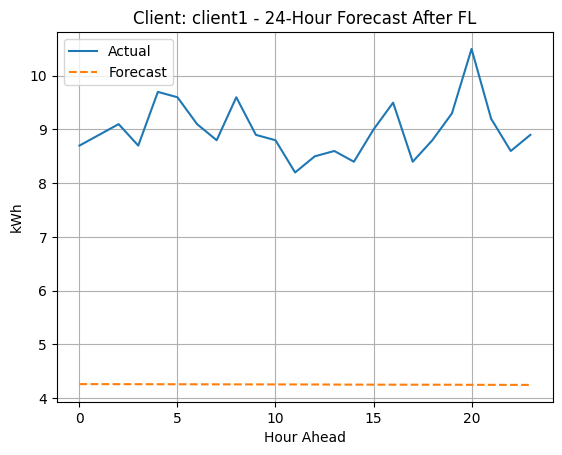

1/1 [==============================] - 1s 1s/step


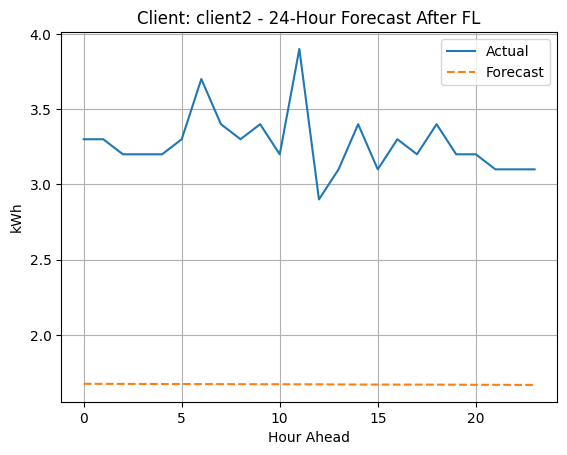

1/1 [==============================] - 1s 1s/step


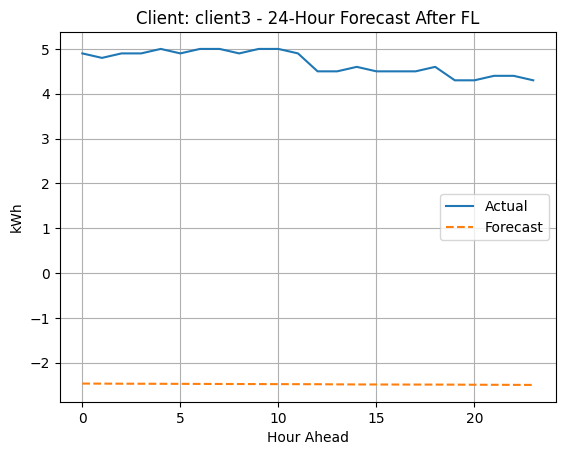

In [ ]:
# Run Forecasting for All Clients
for cid, fp in zip(client_ids, client_files):
    forecast_and_plot(state, fp, cid, N_INPUT, N_OUTPUT)


# New Section